In [28]:
import os
from tkinter import *
from tkinter import filedialog,messagebox,ttk,simpledialog
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from PIL import Image, ImageTk
import pandas as pd
from datetime import date,timedelta,datetime
import csv
import mysql.connector
import numpy as np
from sqlalchemy import create_engine

In [29]:
VERSION='2.61'
#FONT
TITLE_FONT=("Helvetica bold", 20)
HEADING1=("Helvetica bold", 18)
NORM_FONT = ("Helvetica", 15)
FOOTER= ("Helvetica", 10)
#COLOR
TITLE_COLOR='#999EA2'
## 6A685D #53565C #7A848D #D6DCDB #82898D #C1CCC7 *#9DA8AF
#POSITION
POSITION="1068x681+400+200"
#BACKGROUND IMAGE:
BG_IMAGE='Y:\IT Related\Versa\\dist\\light-grey-04.jpg'
SUB_BG_IMAGE='Y:\IT Related\Versa\\dist\\light-grey-18.jpg'

#CONSTANT
ALL_WEST= '("WA", "OR", "ID", "CA", "NV", "UT", "AZ", "AK", "HI","MT","WY", "CO", "NM", "ND", "SD", "NE", "KS", "OK", "TX")'
ALL_EAST = '("MN", "IA", "MO", "WI", "IL", "MI", "IN", "OH", "MA", "VT","ME", "NH", "RI", "CT", "NJ", "DE", "NY", "PA", "MD", "WV",  "KY", "VA", "AR", "LA", "MS", "TN", "AL", "NC", "SC", "GA", "FL")'
WW = '("WA", "OR", "ID", "CA", "NV", "UT", "AZ", "AK", "HI")'
WM = '("MT", "WY", "CO", "NM", "ND", "SD", "NE", "KS", "OK", "TX")'
EN = '("MN", "IA", "MO", "WI", "IL", "MI", "IN", "OH", "MA", "VT", "ME", "NH", "RI", "CT", "NJ", "DE", "NY", "PA", "MD", "WV")'
ES = '("KY", "VA", "AR", "LA", "MS", "TN", "AL", "NC", "SC", "GA", "FL")'
STATES=[('Ww',WW),('Wm',WM),('En',EN),('Es',ES),('All_West',ALL_WEST),('All_East',ALL_EAST)]

#DIR
MYREPORT = "MyReport"
# Get the path to the desktop
DESKTOP = os.path.join(os.path.expanduser("~"), "Desktop")
CURRENT_DIR = os.getcwd()

#CURRENT DATE
TODAY_DATE = datetime.now().strftime('%Y.%m.%d')

#DROP DOWN BOX
MONTH_OPTIONS=['1','2','3','4','5','6','7','8','9','10','11','12','24']

#DATA EXPORT
DATA_EXPORT_LIST={'Sales Report':'Generate a monthly sales report as a CSV File for past 13 months.',
                  'Inventory Report':'Generate a monthly inventory of all Items as a CSV file for past 13 months.',
                  'Shippingfee Report': 'Generate a shippingfee report based on FDW/FEDEX Invoice Hitory.',
                  'Order Processing':'Generate a sales order report from last month to present.',
                  'AIS Item Bin':'Return a report contains bin locations for all AIS items where Onhand > 0.',
                  'DTO Item Bin':'Return a report contains bin locations for all DTO items where Onhand > 0.'
                  }

In [30]:
###DATABASE CONFIGURATION
#AIS Database
config_aisdata={'host':'192.168.26.50',
                'database':'aisdata',
                'user':'root',
                'password':'ais123'
                }
config_aisdata0={'host':'192.168.26.50',
                'database':'aisdata0',
                'user':'root',
                'password':'ais123'
                }
config_aisdata1={'host':'192.168.26.50',
                'database':'aisdata1',
                'user':'root',
                'password':'ais123'
                }
config_aisdata5={'host':'192.168.26.50',
                'database':'aisdata5',
                'user':'root',
                'password':'ais123'
                }
#VERSA Database
config_versa={'host':'192.168.16.130',
              'database':'data1',
              'user':'root',
              'password':'hello123'
             }

##DATABASE QUERY
ORDER_PROCESSING='''
SELECT
saord.Trno AS SalesOrder_No, saord.Trdate AS SalesOrder_Date, saord.Trorig1 AS Sell_Market, saord.Trorig2 AS Sell_Acc, saord.Ordno AS SHIPPER_REF,
saord.Compno AS Cust_ID, saord.Scompany AS ShipTo_CustomerName, saord.Cpono AS Cust_PO, saord.Shipvia AS Ship_VIA, saord.Freight,
saord.Sstatus AS Ship_Status, saord.Sdate AS Ship_Date, saord.Stracno AS Tracking_No,
saordl.Itemno AS Order_Item_SKU, saordl.Ordqty AS Order_QTY,
saord.Company AS BuyerName, saord.Email1 AS BuyerEmail, saord.addr1 AS BuyerAdd1, saord.addr2 AS BuyerAdd2, saord.City AS BuyerCity, saord.State AS BuyerState, saord.Zip AS BuyerZip, saord.Country AS BuyerCountry,
saord.Scompany AS ST_Name, saord.Sphone1 AS ST_Phone, saord.Saddr1 AS ST_Add1, saord.Saddr2 AS ST_Add2, saord.Scity AS ST_City, saord.Sstate AS ST_State, saord.Szip AS ST_Zip, saord.Scountry AS ST_Country,
saord.Subamt AS SUBAMT, saord.Taxamt1 AS TAX, saord.Totamt AS TOTAMT, saordl.Lnno AS LN
FROM saord, saordl
WHERE saord.Trno = saordl.Trno
AND saord.Trdate >= %s
AND saord.Trdate <= %s
ORDER BY saord.Trdate DESC
'''
AIS_ITEM_BIN='''
SELECT *
FROM itemwhse
WHERE Whse in('1','2')
AND (Bin LIKE 'Y%' OR Bin LIKE '0%')
AND Onhand >0
ORDER BY
Itemno,
  CASE 
    WHEN Bin LIKE 'Y%' THEN 0 
    WHEN Bin LIKE '0%' THEN 1
    WHEN RIGHT(Bin, 2) IS NOT NULL THEN 2
  END,
Onhand
'''

DTO_ITEM_BIN='''
SELECT * 
FROM itemwhse
WHERE Whse ='1'
ORDER BY
Itemno,
  CASE 
    WHEN RIGHT(Bin, 2) IS NOT NULL THEN 2
  END,
Onhand
'''

#Products
ITEM='''
select Desc1,Desc2,Sboxlen,Sboxwid,Sboxhei,Sboxwei from item
where Itemno =%s
'''
PRICE='''
select Itemno,round(Avg(Price),2) as Price from sainvl
where Itemno=%s
and Trdate >= %s
and Trdate <%s
'''
SHIPPINGFEE='''
SELECT
Itemno,round(AVG(NetCharge),2) AS NetCharge FROM shippingfee
WHERE Itemno=%s
and InvDate >=%s
and InvDate <%s
'''
INVENTORY='''
SELECT
  Itemno,
  SUM(CASE WHEN Whse = '1' THEN Onhand ELSE 0 END) AS CA1,
  SUM(CASE WHEN Whse = '2' THEN Onhand ELSE 0 END) AS GA2,
  SUM(CASE WHEN Whse = '3' THEN Onhand ELSE 0 END) AS FBA
FROM itemwhse
GROUP BY Itemno;
'''
SHIPPING='''
SELECT * FROM shippingfee
'''

#INVOICE
SAINV_SQL='''
SELECT Trno,Ordno,Trdate,Trtime,Trref,Trorig1,Trorig2,Trorigno,Orddate,Totamt,Compno,Company,Addr1,City,State,Zip,Country,Phone1,Shdate,Sstatus,Sdate,Stracno,Ename,Jouno
FROM sainv
WHERE Trdate>=%s
'''
SHIPPING_RECORD='''
SELECT Ordno
FROM shipping_record
WHERE Trdate>=%s
'''

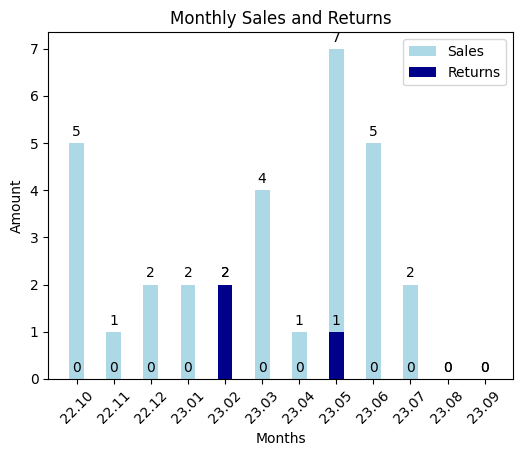

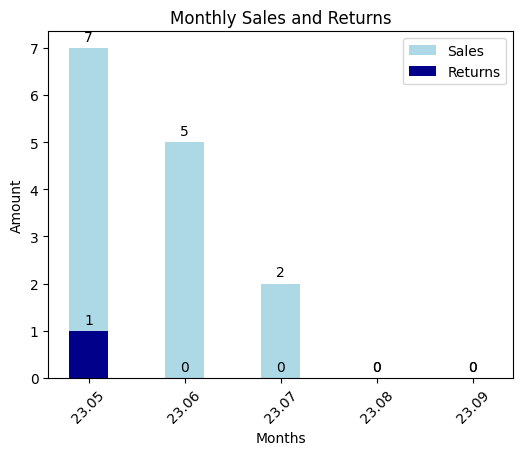

In [33]:
class Create():
    def data(self,db_config, query, params=None):
        try:
            conn = mysql.connector.connect(**db_config)
            with conn.cursor() as cursor:
                if params is not None:
                    cursor.execute(query, params)
                else:
                    cursor.execute(query)
                result = cursor.fetchall()
                df = pd.DataFrame(result, columns=cursor.column_names)
                return df  # Return the result
        except mysql.connector.Error as err:
            messagebox.showinfo('Error',"unable to connect to database")
            print(f"Error: {err}")
        finally:
            conn.close()  # Ensure the connection is closed

    def month(self,num):
        months = []
        end_date1 = datetime.now().replace(day=1).strftime('%Y.%m.%d')
        start_date = (datetime.now() - timedelta(days=30*num)).replace(day=1).strftime('%Y.%m.%d')
        current_date = datetime.strptime(start_date, '%Y.%m.%d')
        end_date2 = datetime.strptime(end_date1, '%Y.%m.%d')
        while current_date < end_date2:
            months.append(current_date.strftime('%Y.%m'))
            current_date += timedelta(days=31)
        return months,start_date,end_date1
    
    def file(self,file_name='',final_table=pd.DataFrame()):
        # Create the folder path
        folder_path = os.path.join(DESKTOP, MYREPORT)
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        #Save the dataframe in CSV File
        FILE_PATH=folder_path+"/"+ file_name
        #Check if the file exists
        try:
            final_table.to_csv(FILE_PATH,index=False)
        except PermissionError as e:
            messagebox.showerror('Permission Denied', f"Permission denied, please close the file '{file_name}' !")
            return    
        if file_name not in os.listdir(folder_path):
            messagebox.showinfo('Failed',f"'{file_name}' Failed to create !")
        else: 
            messagebox.showinfo('Succeeded',f"'{file_name}' has created ! Please check '{MYREPORT}' directory.")
            
class Report():
    def __init__(self):
        self.selected_report=PRODUCT_GUI.selected_report
        self.create=Create()

    def sales_report(self):
        #set variables
        months,start_date,end_date = self.create.month(13)
        file_name=f'AIS SLS Report {start_date}-{end_date}_{TODAY_DATE}.csv'
        #set params        
        query_params = ', '.join([f"SUM(CASE WHEN DATE_FORMAT(sainvl.Trdate, '%Y.%m') = '{month}' THEN sainvl.Ordqty ELSE 0 END) AS '{month}'" for month in months])
        query = f'''
        SELECT 
            sainvl.Itemno, aisdata0.item.Desc1, aisdata0.item.Desc2,aisdata0.item.Adino, 
            {query_params},
            SUM(sainvl.Ordqty) AS TotalSales,
            AVG(sainvl.price) AS 'Avg(SalePrice)', 
            aisdata0.item.Vendno,aisdata0.item.Bin, aisdata0.item.Onhand,aisdata0.item.Oncom,aisdata0.item.Onord,
            aisdata0.item.Price1,aisdata0.item.Price2,aisdata0.item.Price3,aisdata0.item.Price4,aisdata0.item.Price5
        FROM sainvl
        LEFT JOIN aisdata0.item ON sainvl.Itemno = aisdata0.item.Itemno
        WHERE sainvl.Trdate >= %s 
        AND sainvl.Trdate < %s
        GROUP BY Itemno
        ORDER BY Totalsales DESC
        '''
        #Create Data
        sales_df = self.create.data(config_aisdata1,query,(start_date,end_date))
        inventory_df = self.create.data(config_aisdata0,INVENTORY)
        final_table= pd.merge(sales_df, inventory_df, on='Itemno', how='left')
        #Create File
        self.create.file(file_name,final_table)

    def whse_report(self):
        #set variables
        months,start_date,end_date = self.create.month(13)
        file_name=f'Whse SSI Report {start_date}-{end_date}_{TODAY_DATE}.csv'
        #set params      
        query_params = ', '.join([f"SUM(CASE WHEN sainv.Sstate in {STATES[i][1]} THEN sainvl.Ordqty ELSE 0 END) AS {STATES[i][0]} "for i in range(len(STATES))])
        query=f'''
        select
        aisdata1.sainvl.Itemno,
        item.Desc1, item.Desc2, item.Adino, item.Clength, item.Cwidth, item.Ulength, item.Uwidth, 
        item.Uheight, item.Onhand, item.Oncom, item.Onord,item.Bin,
        {query_params},
        SUM(sainvl.Ordqty) AS 'All'
        FROM aisdata1.sainvl
        LEFT JOIN item On aisdata1.sainvl.Itemno=item.Itemno
        LEFT JOIN aisdata1.sainv On aisdata1.sainv.Trno = aisdata1.sainvl.Trno
        Where aisdata1.sainvl.Trdate >=%s
        and aisdata1.sainvl.Trdate < %s
        group by aisdata1.sainvl.Itemno
        '''
        whse_df = self.create.data(config_aisdata0,query,(start_date,end_date))
        for i in range(len(STATES)):
            whse_df[f'{STATES[i][0]}/All %'] = whse_df.apply(lambda row: str(round(row[f'{STATES[i][0]}'] / row['All']*100,2))+'%' if row['All'] != 0 else 0, axis=1)
        inventory_df = self.create.data(config_aisdata0,INVENTORY)#inventory table
        final_table = pd.merge(whse_df, inventory_df, on='Itemno', how='left')
        final_table=final_table.sort_values(by='All',ascending=False)
        #Create File
        self.create.file(file_name,final_table)

    def shipping_report(self):
        file_name=f'Shippingfee Report 2021-06-2023-07_{TODAY_DATE}.csv'
        final_table=self.create.data(config_versa,SHIPPING)
        self.create.file(file_name,final_table)

    def order_processing(self):
        # Custom formatting function for phone numbers
        end_date=TODAY_DATE
        one_month_ago = datetime.now() - timedelta(days=31)
        start_date = one_month_ago.strftime('%Y.%m.%d')
        file_name=f'Order Processing {start_date}-{end_date}_{TODAY_DATE}.csv'
        final_table=self.create.data(config_aisdata1,ORDER_PROCESSING,(start_date,end_date))
        final_table['ST_Phone'] = final_table['ST_Phone'].apply(lambda x: x[1:] if x.startswith('+') else x)
        self.create.file(file_name,final_table)

    def ais_item_bin(self):
        file_name=f'AIS Item Bin_{TODAY_DATE}.csv'
        final_table=self.create.data(config_aisdata0,AIS_ITEM_BIN)
        self.create.file(file_name,final_table)

    def dto_item_bin(self):
        file_name=f'DTO Item Bin_{TODAY_DATE}.csv'
        final_table=self.create.data(config_aisdata5,DTO_ITEM_BIN)
        self.create.file(file_name,final_table)

    def generate_report(self):
        if self.selected_report:
            report_name=self.selected_report.pop()
            result = messagebox.askquestion('Warning','This action may take a while, are you sure to proceed?')
            #Sales Report
            if result=='yes' and report_name=='Sales Report':
                self.sales_report()
            #Whse Report
            elif result=='yes' and report_name=='Inventory Report':
                self.whse_report()
            #Shipping fee
            elif result=='yes' and report_name=='Shippingfee Report':
                self.shipping_report()
            elif result=='yes' and report_name=='Order Processing':
                self.order_processing()
            elif result=='yes' and report_name=='AIS Item Bin':
                self.ais_item_bin()
            elif result=='yes' and report_name=='DTO Item Bin':
                self.dto_item_bin()

class Product():
    def __init__(self):
        self.input_value=PRODUCT_GUI.input_value
        self.combo_value=PRODUCT_GUI.combobox_value
        self.create=Create()

    def update_value(self):
        if self.combo_value==[]:
            selected_months=12
        else:
            selected_months=int(self.combo_value[-1])
        #Parameters
        months,start_date,end_date =self.create.month(selected_months)
        return_params = ', '.join([f"SUM(CASE WHEN DATE_FORMAT(sainvl.Trdate, '%Y.%m') = '{month}' THEN sainvl.Ordqty ELSE 0 END) AS '{month} return'" for month in months])
        sales_params = ', '.join([f"SUM(CASE WHEN DATE_FORMAT(sainvl.Trdate, '%Y.%m') = '{month}' THEN sainvl.Ordqty ELSE 0 END) AS '{month} sales'" for month in months])
        RETURNS=f'''
        SELECT 
        sainvl.Itemno,
        {return_params},
        SUM(sainvl.Ordqty) AS TotalReturn
        FROM samemo
        LEFT JOIN 
        sainvl ON samemo.Invno = sainvl.Trno
        WHERE sainvl.Trdate >= %s 
        AND sainvl.Trdate < %s
        and Itemno= %s
        GROUP BY sainvl.Itemno
        '''
        SALES=f'''
        SELECT 
        sainvl.Itemno,
        {sales_params},
        SUM(sainvl.Ordqty) AS TotalSales
        FROM sainvl
        WHERE sainvl.Trdate >= %s 
        AND sainvl.Trdate < %s
        and Itemno= %s
        GROUP BY sainvl.Itemno
        '''
        
        item=self.create.data(config_aisdata0,ITEM,(self.input_value[-1],))
        price=self.create.data(config_aisdata1,PRICE,(self.input_value[-1],start_date,end_date))
        shippingfee=self.create.data(config_versa,SHIPPINGFEE,(self.input_value[-1],start_date,end_date))
        sales=self.create.data(config_aisdata1,SALES,(start_date,end_date,self.input_value[-1],))
        returns=self.create.data(config_aisdata1,RETURNS,(start_date,end_date,self.input_value[-1],))
        def update_chart(months,item,sales,returns):
            if len(item)!=0:
                months=[i[-5:] for i in months]
                # Create a figure and a subplot
                fig, ax = plt.subplots(figsize=(6,4.5))
                bar_width = 0.4
                x = np.arange(len(months))
                if len(sales)!=0:
                    sales=[int(i) for i in sales.iloc[0,1:-1].tolist()]
                    sales_bars=ax.bar(x, sales, bar_width, label='Sales', color='lightblue')
                if len(returns)!=0:
                    returns=[int(i) for i in returns.iloc[0,1:-1].tolist()]
                    returns_bars=ax.bar(x, returns, bar_width, label='Returns', color='darkblue')
               
                # Set labels and title
                ax.set_xlabel('Months')
                ax.set_ylabel('Amount')
                ax.set_title('Monthly Sales and Returns')
                ax.set_xticks(x)
                ax.set_xticklabels(months,fontsize=10, rotation=45)
                ax.legend()
                # Add numeric labels above each bar
                if (len(sales)!=0 and len(returns)!=0):
                    for bar in sales_bars + returns_bars:
                        height = bar.get_height()
                        ax.annotate(f'{int(height)}',  # Format the label as desired (e.g., with two decimal places)
                                    xy=(bar.get_x() + bar.get_width() / 2, height),
                                    xytext=(0, 3),  # Adjust the vertical offset of the label
                                    textcoords='offset points',
                                    ha='center', va='bottom')
                        
                return fig
            else:
                return False
        fig=update_chart(months,item,sales,returns)
        return item,price,shippingfee,sales,returns,fig

class Bin():
    def __init__(self):
        self.value=PRODUCT_GUI.bin_value
        self.create=Create()
    def generate_query(self):
        ##search the query based on the input
        value=self.value[-1]
        BIN_SEARCH= f'''
        SELECT * FROM itemwhse
        Where itemwhse.Bin like '{value}%'
        ORDER BY itemwhse.itemno ASC;
        '''
        if len(value)>6:
            messagebox.showerror('Failed','Invalid Bin Value! Keep your input length less than 6!')
            return
        else:
            final_table=self.create.data(config_aisdata0, BIN_SEARCH,)
            file_name=f'Bin of {value}_{TODAY_DATE}.csv'
            self.create.file(file_name,final_table)

class Invoice():
    def __init__(self):
        self.path_list=PRODUCT_GUI.path_list
        self.create=Create()

    def generate_report(self):
        trdate=date.today()-timedelta(14)
        current_time = datetime.now()
        formatted=current_time.strftime('%Y-%m-%d-%H%M')
        tbs = pd.DataFrame()
        filtered_table=pd.DataFrame()
        COLUMNS = ['Ordno', 'Price', 'Tracno','Shipvia','Status']

        for file in self.path_list:
            df = pd.read_csv(file)
            base_name = os.path.basename(file)
            base_name=base_name.upper()
            if not any(keyword in base_name for keyword in ['FDW', 'USPS', 'TMS']):
                messagebox.showerror('Error',"Incorrect file! Please choose a 'FDW'/'USPS'/'TMS' file !")
                return
            elif 'FDW' in base_name:
                df['Shipvia']='FDW'
            elif 'USPS' in base_name:
                df['Shipvia']='USPS'
            elif 'TMS' in base_name:
                df['Shipvia']='TMS'
            df['Status']='Unchecked'
            df.columns = COLUMNS
            tbs = pd.concat([tbs, df], ignore_index=True)
            
        tbs = tbs.astype(str)
        tbs = tbs[tbs['Ordno'].apply(lambda x: x.isnumeric() and len(x) == 7)]

        create=Create()
        existing_record=create.data(config_versa,SHIPPING_RECORD,params=(trdate,))
        sql_data=create.data(config_aisdata1,SAINV_SQL,params=(trdate,))#abstract sainv from two weeks ago
        sql_data[['Ordno','Trno','Jouno']] = sql_data[['Ordno','Trno','Jouno']].astype(str)
        final = pd.merge(tbs, sql_data, on='Ordno', how='left')
        final.loc[final['Tracno'] == final['Stracno'], 'Status'] = 'Checked'
        final['Price'].replace('nan','',inplace=True)
        final['UploadDate']=date.today().strftime("%Y-%m-%d")#final table
        unchecked=final[final['Status']=='Unchecked']#unchecked table
        filtered_table= final[~final['Ordno'].isin(existing_record['Ordno'].astype(str))]#import table
        if len(filtered_table)!=0:
            # #Update Database
            db_url = f"mysql://{config_versa['user']}:{config_versa['password']}@{config_versa['host']}/{config_versa['database']}"
            engine = create_engine(db_url)
            table_name = 'shipping_record'
            filtered_table.to_sql(table_name, engine, if_exists='append', index=False, method='multi', chunksize=1000)    

        answer=messagebox.askquestion('Invoice Check',f'Unchecked Items: {len(unchecked)} \nWould you like to continue to export the report?')
        if answer=='yes':
            #Save as report
            folder_path = os.path.join(DESKTOP, MYREPORT)
            if not os.path.exists(folder_path):
                os.makedirs(folder_path)
            file_name=f'Uninvoiced Report {formatted}.csv'
            FILE_PATH=folder_path+"/"+ file_name
            try:
                unchecked.to_csv(FILE_PATH,index=False)
            except PermissionError as e:
                messagebox.showerror('Permission Denied', f"Permission denied, please close the file '{file_name}' !")
                return    
            if file_name not in os.listdir(folder_path):
                messagebox.showinfo('Failed',f"'{file_name}' Failed to create !")
            else: 
                messagebox.showinfo('Succeeded',f"'{file_name}' has created ! Please check '{MYREPORT}' directory.")
            
class PRODUCT_GUI():
    path_list=[]
    combobox_value=[]
    bin_value=[]
    input_value=[]
    selected_report=[]#Data report
    
    def __init__(self,init_window_name):
        self.init_window_name=init_window_name
        self.report = Report()
        self.bin=Bin()
        self.invoice=Invoice()
        self.product=Product()

    def update_combobox_value(self,event):
        self.combobox_value.append(self.drop.get())

    def on_select(self,event):#Report
        self.selected_index = self.list_box.curselection()
        self.selected_report.append(self.list_box.get(self.selected_index[0]))
        if self.selected_index:
            selected_option = self.list_box.get(self.selected_index[0])
            description = DATA_EXPORT_LIST.get(selected_option, 'No description available')
            self.desc_text.delete(1.0, END)  # Clear previous description
            self.desc_text.insert(1.0, selected_option+':\n'+description)
    
    def setup_window(self,window,name,img):
        #background
        img = Image.open(img)
        img = ImageTk.PhotoImage(img)
        panel = Label(window,image=img)
        panel.image = img
        panel.place(x=0,y=0)
        #Initial Setting
        window.title(name)
        window.geometry(POSITION)
        self.header_label=Label(window,text=name,font=HEADING1,bg=TITLE_COLOR,width=100,height=2)        #Hearder
        self.header_label.pack(side=TOP)
        self.footer_label=Label(window,text='Copyright © 2002-2025 Versa Tech. All Rights Reserved. Version '+VERSION,font=FOOTER,bg=TITLE_COLOR,width=200,height=2)
        self.footer_label.pack(side=BOTTOM)#Footer
        
    def nevigation(self,window):
        def help_msg():
            messagebox.showinfo("Help", "Sorry! There is no help.\n\nPlease update any bugs you've found to 'Y:\IT Related\Versa\debug.text\nEvery line of good code is the result of efforts from each of you")
        self.nevig_frame=Frame(window,width=90,height=560, background='#82898D')#Nevigation Frame  relief=RAISED,
        self.nevig_frame.place(relx=0.05, rely=0.515, anchor='center')
        self.help_btn=Button(self.nevig_frame,text='Help',command=help_msg)#exit button
        self.help_btn.place(relx=0.5, rely=0.85, width=80, anchor='center')      
        self.exit_btn=Button(self.nevig_frame,text='Exit',command=window.destroy)#exit button
        self.exit_btn.place(relx=0.5, rely=0.9, width=80, anchor='center')
        return self.nevig_frame
  
    def set_init_window(self):
        #CONSTANT
        BUTTON_DICT={'Data Report':self.report_window,'Product':self.product_window,
                      'Bin Location':self.bin_location_window,'Invoice Check':self.invoice_window,'Order Forecast':self.forcast_window,'Daily Process':self.process_window}
        #Set up window:
        self.setup_window(self.init_window_name,'Ikon Report System',BG_IMAGE)
        self.init_window_name.title('Ikon_Report_V'+VERSION)#窗口名
        #Frame for Button
        self.menu_frame=Frame(self.init_window_name,width=400,height=400,background='#82898D')
        self.menu_frame.place(relx=0.5, rely=0.5, anchor=CENTER)
        def create_buttons(frame):
            items_list=list(BUTTON_DICT.items())
            for i in range(3):
                for j in range(3):
                    index = i * 3 + j
                    if index < len(BUTTON_DICT):
                        key, value = items_list[index]
                        button = Button(frame, text=key,command=value,width=20,height=3)
                        button.grid(row=i, column=j, padx=10, pady=10)
        create_buttons(self.menu_frame)

    def report_window(self):
        self.rpt_window=Toplevel(self.init_window_name)
        self.setup_window(self.rpt_window,'Data Report',SUB_BG_IMAGE)
        self.nevig_frame=self.nevigation(self.rpt_window)
        #Navigation:
        self.export_btn=Button(self.nevig_frame,text='Export',command=self.report.generate_report)#exit button
        self.export_btn.place(relx=0.5, rely=0.1, width=80, anchor='center') 
        #Body
        self.body_frame=Frame(self.rpt_window,width=950,height=560,background='#82898D')#Body Frame
        self.body_frame.place(relx=0.55, rely=0.515, anchor='center')
        self.separator = ttk.Separator(self.body_frame, orient='vertical')
        self.separator.place(relx=0.31, rely=0, relwidth=0.005, relheight=1)
        self.list_label=Label(self.body_frame, text = "AIS Data Report List" ,font = NORM_FONT,background='#82898D').place(relx=0.05,rely=0.02)
        self.list_box=Listbox(self.body_frame,width=28,height=25,font=11)
        self.list_box.place(relx=0.02,rely=0.08)
        self.desc_label=Label(self.body_frame, text = "AIS Data Report Description" ,font = NORM_FONT,background='#82898D').place(relx=0.5,rely=0.02)
        self.desc_text=Text(self.body_frame,width=60,height=20,font=11)
        self.desc_text.place(relx=0.37,rely=0.08)
        for i,key in enumerate(DATA_EXPORT_LIST):
            self.list_box.insert(i,key)
        self.list_box.bind("<<ListboxSelect>>", self.on_select)
        self.rpt_window.grab_set()

    def product_window(self):
        #Setup virtualization window
        self.prod_window=Toplevel(self.init_window_name)
        self.setup_window(self.prod_window,'Products',SUB_BG_IMAGE)
        self.nevigation(self.prod_window)
        
        def create_field(frame):        
            FIELD=['Length(in):','Width(in):','Height(in):','Weight(lb):','Price(avg):','Shipfee(avg):','Total Sales:','Total Returns:','Return Rate:']
            text_array=[]
            for i in range((len(FIELD)//2)+1):
                for j in range(2):
                    index = i * 2 + j
                    if index < len(FIELD):
                        label = Label(frame, text=FIELD[index],width=10,height=1)
                        label.grid(row=i, column=2*j,pady=5)
                        FIELD[index] = Text(frame, width=6,height=1)
                        FIELD[index].grid(row=i, column=2*j+1,padx=2,pady=2)
                        # FIELD[index].grid(row=i, column=2*j+1, padx=6, pady=5)
                        text_array.append(FIELD[index])
            return text_array
                                
        def update_product_info():
            #get input
            self.input_value.append(self.input.get().strip())
            item,price,shippingfee,sales,returns,fig=self.product.update_value()
            text_field=[self.text_desc1,self.text_desc2]+self.text_filed
            #warning message
            if len(item)==0:
                self.warning.place(relx=0.09,rely=0.18)
                for i in text_field:
                    i.delete('1.0','end')
            else:
                self.warning.place_forget()
                for i in text_field:
                    i.delete('1.0','end')
                self.text_desc1.insert(END,item['Desc1'][0])#desc1
                self.text_desc2.insert(END,item['Desc2'][0])#desc2
                self.text_filed[0].insert(END,item['Sboxlen'][0])#length
                self.text_filed[1].insert(END,item['Sboxwid'][0])#width
                self.text_filed[2].insert(END,item['Sboxhei'][0])#height
                self.text_filed[3].insert(END,item['Sboxwei'][0])#weight
                self.text_filed[4].insert(END,0 if price['Price'][0]==None else price['Price'][0])#price
                self.text_filed[5].insert(END,0 if shippingfee['Itemno'][0]==None else shippingfee['NetCharge'][0])#shipfee
                self.text_filed[6].insert(END,0 if len(sales)==0 else sales['TotalSales'][0])#Total Sale
                self.text_filed[7].insert(END,0 if len(returns)==0 else returns['TotalReturn'][0])#Total Returns
                self.text_filed[8].insert(END,0 if (len(sales)==0 or len(returns)==0) else str(round((returns['TotalReturn'][0] / sales['TotalSales'][0] * 100),2))+"%")#Return Rate
                #display chart
                self.canvas = FigureCanvasTkAgg(fig, master=self.body_frame)
                self.canvas=self.canvas.get_tk_widget()
                self.canvas.place(relx=0.66, rely=0.515, anchor='center')

        #Frame
        self.body_frame=Frame(self.prod_window,width=950,height=560,background='#82898D')#Body Frame
        self.body_frame.place(relx=0.55, rely=0.515, anchor='center')
        #Separator object
        self.separator = ttk.Separator(self.body_frame, orient='vertical')
        self.separator.place(relx=0.31, rely=0, relwidth=0.005, relheight=1)
        #search bar:
        self.frm_search=Frame(self.body_frame,width=300,height=60)
        self.frm_search.place(relx=0.005,rely=.11)
        self.label=Label(self.frm_search,text='Item ID:').pack(side='left') #Item ID
        entry_text =StringVar()
        self.input=Entry(self.frm_search,width=24,font=('Arial 10'), textvariable=entry_text)
        self.input.pack(side='left',padx=4,pady=5)#Input
        # Function to update the variable with uppercase text
        def update_entry_text(*args):
            entry_text.set(entry_text.get().upper())
        entry_text.trace_add("write", update_entry_text)
        self.search_btn=Button(self.frm_search,width=6,text='search',command=update_product_info)#Button
        self.search_btn.pack(side='right',padx=4,pady=5)
        self.prod_window.bind('<Return>',lambda event:update_product_info())
        self.warning=Label(self.body_frame,text='Invalid Item ID !',font='9',foreground='red',background='#82898D')#warning message
        #Info panel
        self.frm_des=Frame(self.body_frame)
        self.frm_des.place(relx=0.005,rely=.24)
        self.lab_desc1=Label(self.frm_des,text='Description 1:').grid(row=0, column=0)  #DESC1
        self.text_desc1=Text(self.frm_des,width=25,height=2)
        self.text_desc1.grid(row=0, column=1, padx=3, pady=2)
        self.lab_desc2=Label(self.frm_des,text='Description 2:').grid(row=1, column=0) #DESC2
        self.text_desc2=Text(self.frm_des,width=25,height=2)
        self.text_desc2.grid(row=1, column=1, padx=3, pady=2)
        #Dimension
        self.frm_dim=Frame(self.body_frame,highlightthickness=11.5)
        self.frm_dim.place(relx=0.005,rely=0.39)
        #Fill all input
        self.text_filed=create_field(self.frm_dim)
        self.drop_label=Label(self.frm_dim, text = "Select month:" )#Drop down box
        self.drop_label.place(relx=0.64, rely=0.89,anchor='center')
        self.drop= ttk.Combobox(self.frm_dim,values =MONTH_OPTIONS)
        self.drop.current(11)
        self.drop.place(relx=0.89, rely=0.89,width=53,height=22, anchor='center')
        self.drop.bind("<<ComboboxSelected>>", self.update_combobox_value)        

    def bin_location_window(self):
        self.bin_window=Toplevel(self.init_window_name)
        self.setup_window(self.bin_window,'Bin Location Search',SUB_BG_IMAGE)
        self.nevigation(self.bin_window)

        self.dialog_value = simpledialog.askstring("Input", "Enter a Bin Location:")
        if self.dialog_value is None:  # User clicked "Cancel"
            self.bin_window.destroy()
            return
 
        #Text Window
        self.bin_value.append(self.dialog_value)
        self.text_label=Label(self.bin_window,text='Selected Files：',font=NORM_FONT)# Selected Files
        self.text_label.place(relx=0.5, rely=0.2, anchor=CENTER)
        self.my_text=Text(self.bin_window,width=40,height=10,font=("Helvetica", 16), selectbackground="yellow", selectforeground="black", undo=True)
        self.my_text.place(relx=0.5, rely=0.4, anchor=CENTER)
        self.my_text.insert(END,self.dialog_value+'\n')

        #Button
        self.create_btn=Button(self.bin_window,text='Create',command=self.bin.generate_query,width=10)
        self.create_btn.place(relx=0.45, rely=0.6, anchor=CENTER)
        self.exit_btn=Button(self.bin_window,text='Exit',command=self.bin_window.destroy,width=10)
        self.exit_btn.place(relx=0.55, rely=0.6, anchor=CENTER)
        self.bin_window.grab_set()
        
    def invoice_window(self):
        #Setup Invoice window
        self.inv_window=Toplevel(self.init_window_name)
        self.setup_window(self.inv_window,'Invoice Check',SUB_BG_IMAGE)
        self.nevigation(self.inv_window)

        def open_invoice_csv():
            csv_file= filedialog.askopenfilenames(initialdir=CURRENT_DIR,title='Open CSV File',filetypes=(('CSV Files','*.csv'),))
            for i in csv_file:
                filepath=os.path.abspath(i)
                filename=os.path.basename(filepath)
                if filename[-3:].upper()!='CSV':
                    messagebox.showerror('Error','Incorrect File Names, Please upload CSV files!')
                else:
                    self.path_list.append(filepath)
                    self.my_text.insert(END,filename+'\n')
        def clear():
            self.path_list.clear()
            self.my_text.delete(1.0, END)  # Clear previous description
 
        #Text Window
        self.text_label=Label(self.inv_window,text='Selected Files：',font=NORM_FONT)# Selected Files
        self.text_label.place(relx=0.5, rely=0.2, anchor=CENTER)
        self.my_text=Text(self.inv_window,width=40,height=10,font=("Helvetica", 16), selectbackground="yellow", selectforeground="black", undo=True)
        self.my_text.place(relx=0.5, rely=0.4, anchor=CENTER)

        #Button
        self.open_btn=Button(self.inv_window,text='Open CSV Files',command=open_invoice_csv,width=15)
        self.open_btn.place(relx=0.42, rely=0.6, anchor=CENTER)
        self.clear_btn=Button(self.inv_window,text='Clear',command=clear,width=15)
        self.clear_btn.place(relx=0.58, rely=0.6, anchor=CENTER)

        self.create_btn=Button(self.inv_window,text='Check',command=self.invoice.generate_report,width=10)
        self.create_btn.place(relx=0.45, rely=0.7, anchor=CENTER)
        self.exit_btn=Button(self.inv_window,text='Exit',command=self.inv_window.destroy,width=10)
        self.exit_btn.place(relx=0.55, rely=0.7, anchor=CENTER)
        self.inv_window.grab_set()

    def forcast_window(self):
        self.frcs_window=Toplevel(self.init_window_name)
        self.setup_window(self.frcs_window,'Order Forcasting',SUB_BG_IMAGE)
        self.nevigation(self.frcs_window)
        messagebox.showinfo("Information", "This feature is not currently available. Please stay tuned.")
        self.frcs_window.focus()
        # self.frcs_window.grab_set()

    def process_window(self):
        self.procs_window=Toplevel(self.init_window_name)
        self.setup_window(self.procs_window,'Daily Processing',SUB_BG_IMAGE)
        self.nevigation(self.procs_window)
        messagebox.showinfo("Information", "This button is here to just look good")
        self.procs_window.focus()

def product_start():
    init_window=Tk()
    ZMJ_PROTAL = PRODUCT_GUI(init_window)
    #设置根窗口默认属性
    ZMJ_PROTAL.set_init_window()
    init_window.mainloop()

product_start()